In [49]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


In [50]:
# Read the CSV data into the pandas dataframe
file = '../data/data.csv'
data = pd.read_csv(file)

In [51]:
# Let's replace the label column values to 0 for normal and 1 for others!

LABELS = data["label"].unique() # Get Unique Values of label column
LABELS = [label for label in LABELS if label != "normal"] #All labels other than Normal!

data["label"].replace(['normal'], 0, inplace=True)
data["label"].replace(LABELS, 1 , inplace=True)


/tmp/ipykernel_14318/1288935411.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["label"].replace(['normal'], 0, inplace=True)
/tmp/ipykernel_14318/1288935411.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["label"].replace(LABELS, 1 , inplace=True)


In [52]:
data = data.fillna("None") # fill all the empty hosts with 0

#Now let's encode all the columns which are not float or int e.g. sourceIP, MAC to make it possible for model to interpret
columnsToEncode = list(data.select_dtypes(include=['category', 'object']))  
            
le = LabelEncoder() # use label encoder from sklearn

for feature in columnsToEncode:
    try:
        data[feature] = le.fit_transform(data[feature])
        #print(data[feature])
    except:
        print ('error' + feature)


In [53]:
data.head()

,Unnamed: 0,uid,sourceMac,sourceIp,destIp,destMac,sourcePort,destPort,host,kIn,...,outPacketsNo,protocol,urgent,ack,push,reset,syn,fin,timestamp,label
0,0,10242,36,65,20,88,9443,50766,0,0.732002,...,45,19,1,0,1,0,0,1,36057,1
1,1,9488,8,44,81,82,1483,14923,6,0.180812,...,89,19,1,0,1,0,0,1,25629,0
2,2,5683,49,49,22,98,43023,7183,3,0.470744,...,89,9,0,0,0,1,0,1,50388,1
3,3,1354,2,55,29,42,18033,57757,5,0.049469,...,95,16,1,0,0,0,0,0,35092,1
4,4,8222,53,80,70,16,54098,30837,4,0.713512,...,15,3,1,0,0,1,1,1,94968,0


In [54]:
data["label"].value_counts()

label
1    13750
0    11250
Name: count, dtype: int64

In [55]:
Train, Val = sklearn.model_selection.train_test_split(data, test_size=0.9, random_state=1, shuffle=True)

In [56]:
Train["label"].value_counts()

label
1    1360
0    1140
Name: count, dtype: int64

In [57]:
Val["label"].value_counts()

label
1    12390
0    10110
Name: count, dtype: int64

In [58]:
Attack = Train[Train['label']==1]
Normal = Train[Train['label']==0]
# Check if there are normal samples in the training dataset
if len(Normal) == 0:
    print("Error: No normal samples found in the training dataset.")
    # Handle this case according to your requirements, such as setting a default value
    outlier_fraction = 0.1  # Set a default value
else:
    # Calculate outlier fraction only if there are normal samples
    outlier_fraction = np.ceil(len(Attack) / float(len(Normal)))


#Let's print how many more outliers are there in the dataset compared to normal data
print("Outlier fraction:", outlier_fraction)

Outlier fraction: 2.0


In [59]:
#Let's now split the features and the target ground truth
features = [feature for feature in Train.columns.tolist() if feature not in ["label"]]
target = "label"

# Define a random state 
state = np.random.RandomState(42)
X_train = Train[features]
Y_train = Train[target]

X_val = Val[features]
Y_val = Val[target]

X_outliers = state.uniform(low=0, high=1, size=(X_train.shape[0], X_train.shape[1]))
# Print the shapes of X & Y
print(X_train.shape)
print(Y_train.shape)

(2500, 20)
(2500,)


In [60]:
#Let's initalize some classifiers
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X_train), 
                                       contamination=outlier_fraction,random_state=state, verbose=1),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=0.03),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1 )
   
}

In [61]:
n_outliers = len(Attack)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        continue
        y_pred = clf.fit_predict(X_train)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X_train)
        y_pred = clf.predict(X_train)
    else:    
        continue
        clf.fit(X_train)
        scores_prediction = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)
        
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y_train).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y_train,y_pred))
    print("Classification Report :")
    print(classification_report(Y_train,y_pred))


Support Vector Machine: 1208
Accuracy Score :
0.5168
Classification Report :
              precision    recall  f1-score   support

           0       0.43      0.19      0.26      1140
           1       0.54      0.79      0.64      1360

    accuracy                           0.52      2500
   macro avg       0.48      0.49      0.45      2500
weighted avg       0.49      0.52      0.47      2500



In [62]:
n_outliers = len(Attack)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        continue
        y_pred = clf.fit_predict(X_train)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X_train)
        y_pred = clf.predict(X_train)
    else:    
        continue
        clf.fit(X_train)
        scores_prediction = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)
        
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y_train).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y_train,y_pred))
    print("Classification Report :")
    print(classification_report(Y_train,y_pred))


Support Vector Machine: 1208
Accuracy Score :
0.5168
Classification Report :
              precision    recall  f1-score   support

           0       0.43      0.19      0.26      1140
           1       0.54      0.79      0.64      1360

    accuracy                           0.52      2500
   macro avg       0.48      0.49      0.45      2500
weighted avg       0.49      0.52      0.47      2500



In [63]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

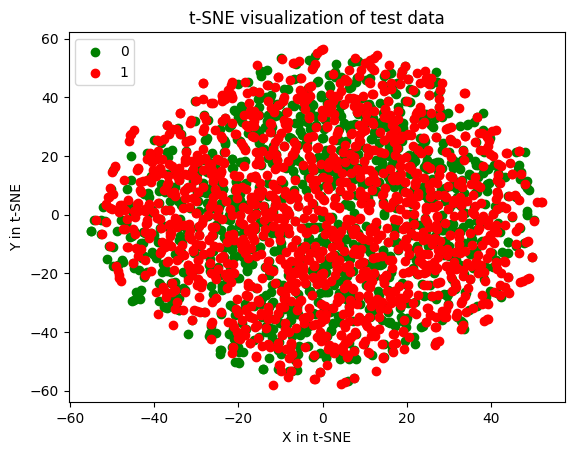

In [64]:
def tsne_plot(x1, y1, name="graph.png"):
    
    #Scale features to improve the training ability of TSNE.
    standard_scaler = StandardScaler()
    df2_std = standard_scaler.fit_transform(x1)

    tsne = TSNE(n_components=2, random_state=0)
    x_test_2d = tsne.fit_transform(df2_std)
    
    #Build the scatter plot with the two types of transactions.
    color_map = {0:'green', 1:'red'}
    plt.figure()
    for idx, cl in enumerate(np.unique(y1)):
        plt.scatter(x = x_test_2d[y1==cl,0], 
                    y = x_test_2d[y1==cl,1], 
                    c = color_map[idx], 
                    label = cl)
    plt.xlabel('X in t-SNE')
    plt.ylabel('Y in t-SNE')
    plt.legend(loc='upper left')
    plt.title('t-SNE visualization of test data')
    plt.show()
    
tsne_plot(X_train[:8000], Y_train[:8000])


In [65]:
#I think training this kind of dataset with autoencoders makes more sense so let's try that

## input layer 
input_layer = Input(shape=(X_train.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X_train.shape[1], activation='relu')(decoded)

In [66]:
#Compile the mdoel
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [67]:
#let's do bit of data transformation for scaling

x = X_train
y = Y_train

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [68]:
autoencoder.fit(x_norm[0:8000], x_norm[0:8000], 
                batch_size = 256, epochs = 50, 
                shuffle = True, validation_split = 0.20);

Epoch 1/50
4/4 [==============================] - 1s 93ms/step - loss: 0.3136 - val_loss: 0.3086
Epoch 2/50
4/4 [==============================] - 0s 23ms/step - loss: 0.3135 - val_loss: 0.3085
Epoch 3/50
4/4 [==============================] - 0s 22ms/step - loss: 0.3133 - val_loss: 0.3083
Epoch 4/50
4/4 [==============================] - 0s 18ms/step - loss: 0.3132 - val_loss: 0.3082
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 0.3131 - val_loss: 0.3081
Epoch 6/50
4/4 [==============================] - 0s 16ms/step - loss: 0.3129 - val_loss: 0.3079
Epoch 7/50
4/4 [==============================] - 0s 14ms/step - loss: 0.3128 - val_loss: 0.3078
Epoch 8/50
4/4 [==============================] - 0s 14ms/step - loss: 0.3127 - val_loss: 0.3077
Epoch 9/50
4/4 [==============================] - 0s 13ms/step - loss: 0.3125 - val_loss: 0.3075
Epoch 10/50
4/4 [==============================] - 0s 14ms/step - loss: 0.3124 - val_loss: 0.3074
Epoch 11/50
4/4 [============

In [69]:
#Let's try to get latent learnt representation by autoencoder
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [70]:
norm_hid_rep = hidden_representation.predict(x_norm[900:1200])
fraud_hid_rep = hidden_representation.predict(x_fraud[900:1200])


10/10 [==============================] - 0s 3ms/step


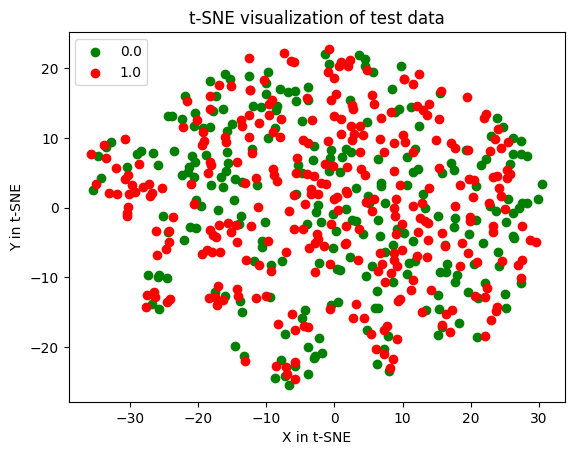

In [71]:
#Let's try to visualize TSNE again for the learnt representation
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

tsne_plot(rep_x, rep_y)

In [72]:
#Finally we can train a classifier on learnt representations

train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.40      0.24      0.30        58
         1.0       0.56      0.73      0.63        77

    accuracy                           0.52       135
   macro avg       0.48      0.48      0.47       135
weighted avg       0.49      0.52      0.49       135


Accuracy Score:  0.5185185185185185


In [73]:
#Finally we can train a classifier on learnt representations

train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(X_train, Y_train)
pred_y = clf.predict(X_val)

print ("")
print ("Classification Report: ")
print (classification_report(Y_val, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(Y_val, pred_y))


Classification Report: 
              precision    recall  f1-score   support

           0       0.50      0.34      0.40     10110
           1       0.57      0.72      0.64     12390

    accuracy                           0.55     22500
   macro avg       0.54      0.53      0.52     22500
weighted avg       0.54      0.55      0.53     22500


Accuracy Score:  0.5508888888888889


/home/vanessuniq/jojo/Network-Anomaly-Detection/env_name/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
